In [3]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from pandas import Timedelta
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib  # for saving models
import os

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


### Data Description

Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

In [4]:
telemetry_raw = pd.read_csv("Data/PdM_telemetry.csv")
errors_raw = pd.read_csv("Data/PdM_errors.csv")
maintenance_raw = pd.read_csv("Data/PdM_maint.csv")
failures_raw = pd.read_csv("Data/PdM_failures.csv")
metadata_raw = pd.read_csv("Data/PdM_machines.csv")

datasets = {"telemetry": telemetry_raw, "errors": errors_raw, "maintenance": maintenance_raw, "failures": failures_raw, "metadata": metadata_raw}

### Exploratory Data Analysis (EDA)

In [4]:
for k,v in datasets.items():
    print(f"Size of {k} dataset:", v.shape)

Size of telemetry dataset: (876100, 6)
Size of errors dataset: (3919, 3)
Size of maintenance dataset: (3286, 3)
Size of failures dataset: (761, 3)
Size of metadata dataset: (100, 3)


In [5]:
telemetry_raw.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


In [6]:
metadata_raw.head(2)

,machineID,model,age
0,1,model3,18
1,2,model4,7


In [5]:
# Makes sense to add machine metadata alongside machine telemetry to act as predictors

feature_df = pd.merge(telemetry_raw, metadata_raw, on="machineID", how = "outer")
assert feature_df.shape[0] == telemetry_raw.shape[0]
feature_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18


In [8]:
print(f"The first and last datetime for telemetry observations are {feature_df['datetime'].sort_values().min()} and {feature_df['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for error observations are {errors_raw['datetime'].sort_values().min()} and {errors_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for failure observations are {failures_raw['datetime'].sort_values().min()} and {failures_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for maintenance observations are {maintenance_raw['datetime'].sort_values().min()} and {maintenance_raw['datetime'].sort_values().max()} respectively")

The first and last datetime for telemetry observations are 2015-01-01 06:00:00 and 2016-01-01 06:00:00 respectively
The first and last datetime for error observations are 2015-01-01 06:00:00 and 2016-01-01 05:00:00 respectively
The first and last datetime for failure observations are 2015-01-02 03:00:00 and 2015-12-31 06:00:00 respectively
The first and last datetime for maintenance observations are 2014-06-01 06:00:00 and 2016-01-01 06:00:00 respectively


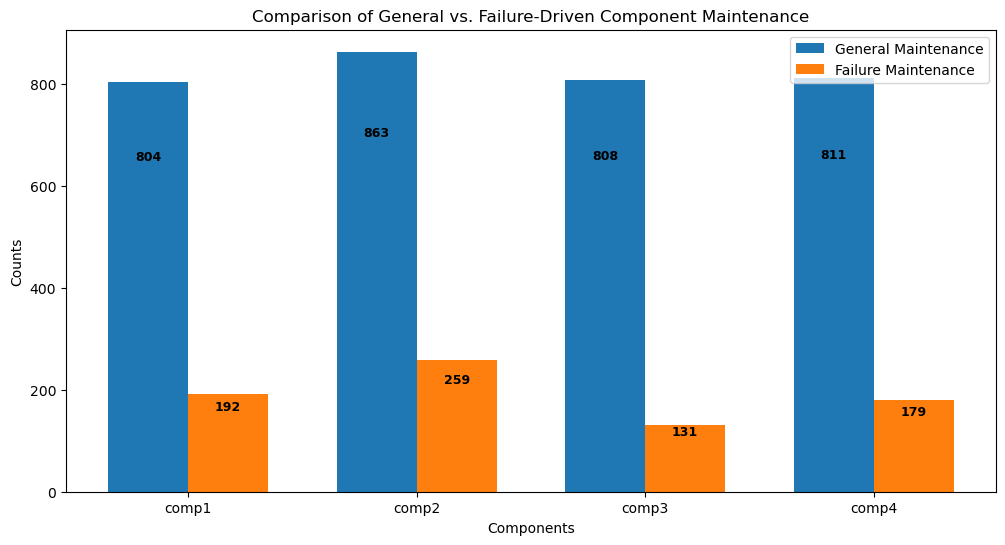

In [12]:
# Is a certain component more fragile/susceptible to maintenance? 

failure_dict = failures_raw['failure'].value_counts().to_dict()
maint_dict = maintenance_raw['comp'].value_counts().to_dict()

components = list(failure_dict.keys())
components.sort()
failure_counts = [failure_dict.get(comp) for comp in components]
maint_counts = [maint_dict.get(comp) for comp in components]

# Set positions for bars
x = np.arange(len(components))
width = 0.35  # width of the bars

# Plot bars side-by-side
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, maint_counts, width, label='General Maintenance')
bars2 = ax.bar(x + width/2, failure_counts, width, label='Failure Maintenance')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width()/2, 0.8*height),
                xytext=(0, 0),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labeling and titles
ax.set_xlabel('Components')
ax.set_ylabel('Counts')
ax.set_title('Comparison of General vs. Failure-Driven Component Maintenance')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()

<BarContainer object of 5 artists>

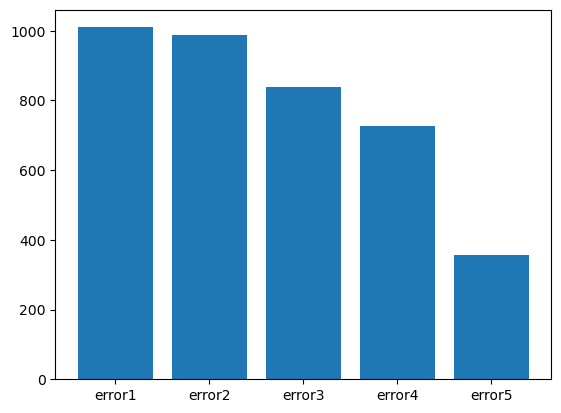

In [13]:
error_dict = errors_raw['errorID'].value_counts().to_dict()
plt.bar(error_dict.keys(),error_dict.values())

In [6]:
failure_error_maint = pd.concat([failures_raw, errors_raw, maintenance_raw])

feature_df["datetime"] = pd.to_datetime(feature_df["datetime"])
failure_error_maint["datetime"] = pd.to_datetime(failure_error_maint["datetime"])

compiled_df = pd.merge(feature_df,failure_error_maint,on=["datetime","machineID"], how="left")
print(compiled_df.shape)

(877878, 11)


In [7]:
df = pd.get_dummies(compiled_df, columns=["errorID", "comp"])
cols = [col for col in df.columns if col.startswith(("errorID", "comp"))]
df[cols] = df[cols].astype(int)

agg_dict = {
    'volt': 'first',      # or 'mean', depending on your needs
    'rotate': 'first',
    'pressure': 'first',
    'vibration': 'first',
    'model': 'first',
    'age': 'first',
    'failure':'first',
    'errorID_error1': 'sum',
    'errorID_error2': 'sum',
    'errorID_error3': 'sum',
    'errorID_error4': 'sum',
    'errorID_error5': 'sum',
    'comp_comp1': 'sum',
    'comp_comp2': 'sum',
    'comp_comp3': 'sum',
    'comp_comp4': 'sum'
}

# Group by 'datetime' and 'machineID' and aggregate
grouped_df = df.groupby(['datetime', 'machineID'], as_index=False).agg(agg_dict).sort_values(["machineID","datetime"]).reset_index(drop=True)

In [8]:
# Label all telemetry 24 hours prior to a failure 

grouped_df['label'] = grouped_df['failure'].fillna(method='bfill', limit=24)
grouped_df.head()

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_1283/1655466464.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grouped_df['label'] = grouped_df['failure'].fillna(method='bfill', limit=24)


,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,comp_comp1,comp_comp2,comp_comp3,comp_comp4,label
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,None,0,0,0,0,0,0,0,0,0,None
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,None,0,0,0,0,0,0,0,0,0,None
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,None,0,0,0,0,0,0,0,0,0,None
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,None,0,0,0,0,0,0,0,0,0,None
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,None,0,0,0,0,0,0,0,0,0,None


In [9]:
def add_days_since_replacement(main_df, maintenance_df):
    """
    For each component replacement column in main_df (columns starting with "comp_comp"),
    calculates the number of days since the last replacement event.
    
    Replacement events come from:
      - main_df itself (where a 'comp_compX' column equals 1), and
      - maintenance_df (which has columns 'datetime', 'machineID', 'comp')
    
    The function groups by machineID to ensure that within each group the datetime column is sorted.
    
    Parameters:
        main_df (pd.DataFrame): Main dataframe containing columns such as 'datetime', 'machineID',
            and replacement indicator columns (e.g., 'comp_comp1', 'comp_comp2', ...)
        maintenance_df (pd.DataFrame): DataFrame containing maintenance events with columns:
            'datetime', 'machineID', 'comp' (e.g., 'comp2', 'comp4', etc.)
            
    Returns:
        pd.DataFrame: main_df with additional columns 'days_since_compX' added for each component.
    """
    # Copy data and ensure datetime conversion
    main_df = main_df.copy()
    maintenance_df = maintenance_df.copy()
    main_df['datetime'] = pd.to_datetime(main_df['datetime'])
    maintenance_df['datetime'] = pd.to_datetime(maintenance_df['datetime'])
    
    # Identify component replacement columns in main_df
    comp_columns = [col for col in main_df.columns if col.startswith('comp_comp')]
    
    # List to store updated groups
    updated_groups = []
    
    # Process each machine separately
    for machine, group in main_df.groupby('machineID'):
        # Sort group by datetime
        group_sorted = group.sort_values('datetime').reset_index(drop=True)
        
        # Process each component for this machine
        for col in comp_columns:
            comp_name = col.replace("comp_", "")  # e.g., "comp_comp1" -> "comp1"
            
            # Replacement events from main_df where that component was replaced
            main_events = group_sorted.loc[group_sorted[col] == 1, ['datetime']].copy()
            main_events['component'] = comp_name
            
            # Replacement events from maintenance_df for this machine and component
            maint_events = maintenance_df[
                (maintenance_df['machineID'] == machine) &
                (maintenance_df['comp'] == comp_name)
            ][['datetime']].copy()
            maint_events['component'] = comp_name
            
            # Combine the events and sort by datetime
            comp_events = pd.concat([main_events, maint_events], ignore_index=True)
            comp_events = comp_events.sort_values('datetime').reset_index(drop=True)
            
            # If there are no replacement events for this component, add a column with NaN and continue.
            new_col = f'days_since_{comp_name}'
            if comp_events.empty:
                group_sorted[new_col] = np.nan
                continue
            
            # Rename the right-hand side datetime column to avoid conflict
            comp_events = comp_events.rename(columns={"datetime": "comp_datetime"})
            
            # Merge as-of: for each row in group_sorted, attach the most recent replacement event.
            merged = pd.merge_asof(
                group_sorted,
                comp_events,
                left_on='datetime',
                right_on='comp_datetime',
                direction='backward'
            )
            
            # Compute days since last replacement.
            merged[new_col] = (merged['datetime'] - merged['comp_datetime']).dt.days
            
            # Update group_sorted with the new column.
            group_sorted[new_col] = merged[new_col]
        
        updated_groups.append(group_sorted)
    
    # Concatenate the groups back together
    result_df = pd.concat(updated_groups, ignore_index=True)
    return result_df

# Example usage:
final_features = add_days_since_replacement(grouped_df, maintenance_raw)

In [10]:
final_features = final_features.drop(["comp_comp1", "comp_comp2","comp_comp3","comp_comp4"],axis=1)

In [11]:
final_features.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,label,days_since_comp1,days_since_comp2,days_since_comp3,days_since_comp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,None,0,0,0,0,0,None,19,214,154,169
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,None,0,0,0,0,0,None,19,214,154,169


In [40]:
telemetry_cols = ['volt', 'rotate', 'pressure', 'vibration']
for col in telemetry_cols:
    # 24-hour rolling mean
    final_features[col + '_24h_mean'] = final_features.groupby('machineID')[col].transform(
        lambda x: x.rolling(window=24, min_periods=1).mean())
    # 24-hour rolling standard deviation
    final_features[col + '_24h_std'] = final_features.groupby('machineID')[col].transform(
        lambda x: x.rolling(window=24, min_periods=1).std())
    final_features[col + '_3h_mean'] = final_features.groupby('machineID')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean())
    final_features[col + '_3h_std'] = final_features.groupby('machineID')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1).std())
    # Optionally, include a lag feature (previous hour's value)
    final_features[col + '_lag1'] = final_features.groupby('machineID')[col].shift(1)

# (Optional) Aggregate error counts if needed or use them directly:
# For example, you could sum error counts across all error types.
final_features['total_errors'] = final_features[['errorID_error1', 'errorID_error2', 
                         'errorID_error3', 'errorID_error4', 
                         'errorID_error5']].sum(axis=1)

In [41]:
final_features.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'model', 'age', 'failure', 'errorID_error1', 'errorID_error2',
       'errorID_error3', 'errorID_error4', 'errorID_error5', 'label',
       'days_since_comp1', 'days_since_comp2', 'days_since_comp3',
       'days_since_comp4', 'volt_24h_mean', 'volt_24h_std', 'volt_3h_mean',
       'volt_3h_std', 'volt_lag1', 'rotate_24h_mean', 'rotate_24h_std',
       'rotate_3h_mean', 'rotate_3h_std', 'rotate_lag1', 'pressure_24h_mean',
       'pressure_24h_std', 'pressure_3h_mean', 'pressure_3h_std',
       'pressure_lag1', 'vibration_24h_mean', 'vibration_24h_std',
       'vibration_3h_mean', 'vibration_3h_std', 'vibration_lag1',
       'total_errors'],
      dtype='object')

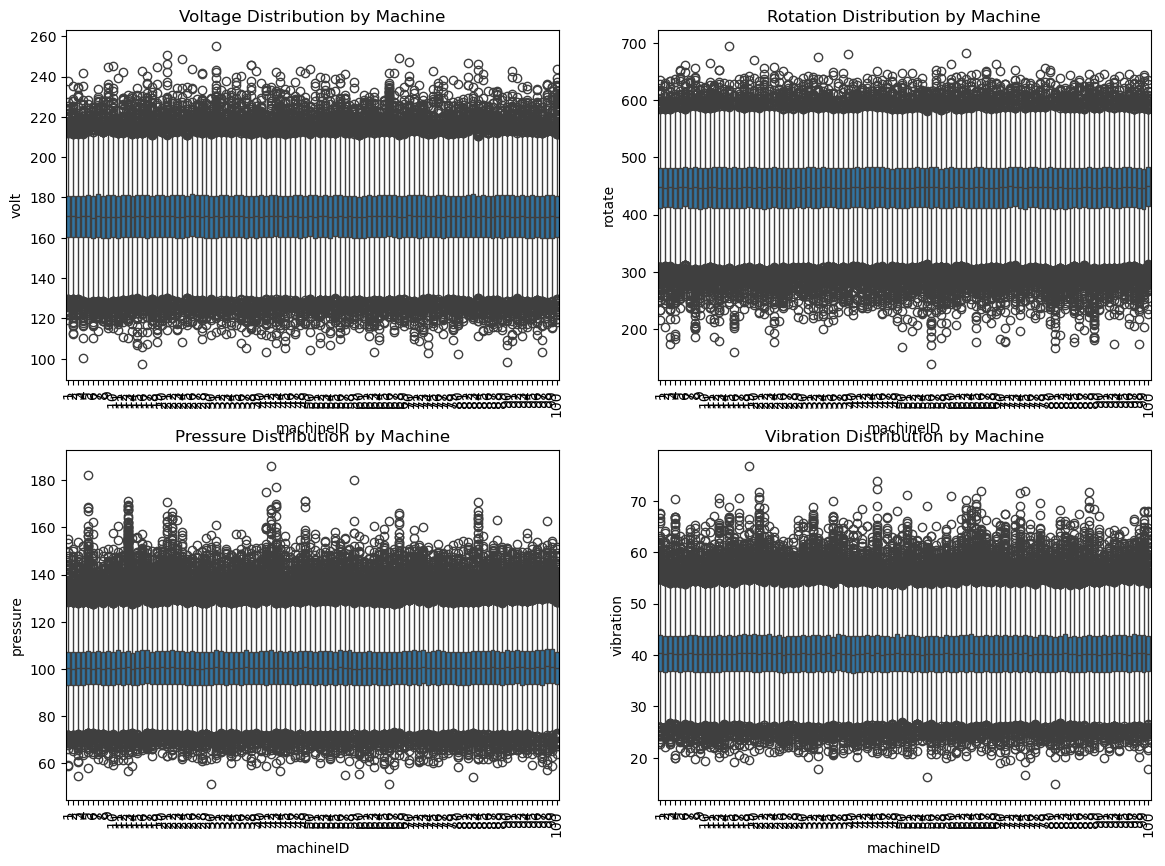

In [225]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# First plot: Voltage Distribution
sns.boxplot(x='machineID', y='volt', data=final_features, ax=axs[0, 0])
axs[0, 0].set_title('Voltage Distribution by Machine')
axs[0, 0].tick_params(axis='x', rotation=90)  # Rotate x-labels if needed

# Second plot: Rotation Distribution
sns.boxplot(x='machineID', y='rotate', data=final_features, ax=axs[0, 1])
axs[0, 1].set_title('Rotation Distribution by Machine')
axs[0, 1].tick_params(axis='x', rotation=90)

# Third plot: Pressure Distribution
sns.boxplot(x='machineID', y='pressure', data=final_features, ax=axs[1, 0])
axs[1, 0].set_title('Pressure Distribution by Machine')
axs[1, 0].tick_params(axis='x', rotation=90)

# Fourth plot: Vibration Distribution
sns.boxplot(x='machineID', y='vibration', data=final_features, ax=axs[1, 1])
axs[1, 1].set_title('Vibration Distribution by Machine')
axs[1, 1].tick_params(axis='x', rotation=90)

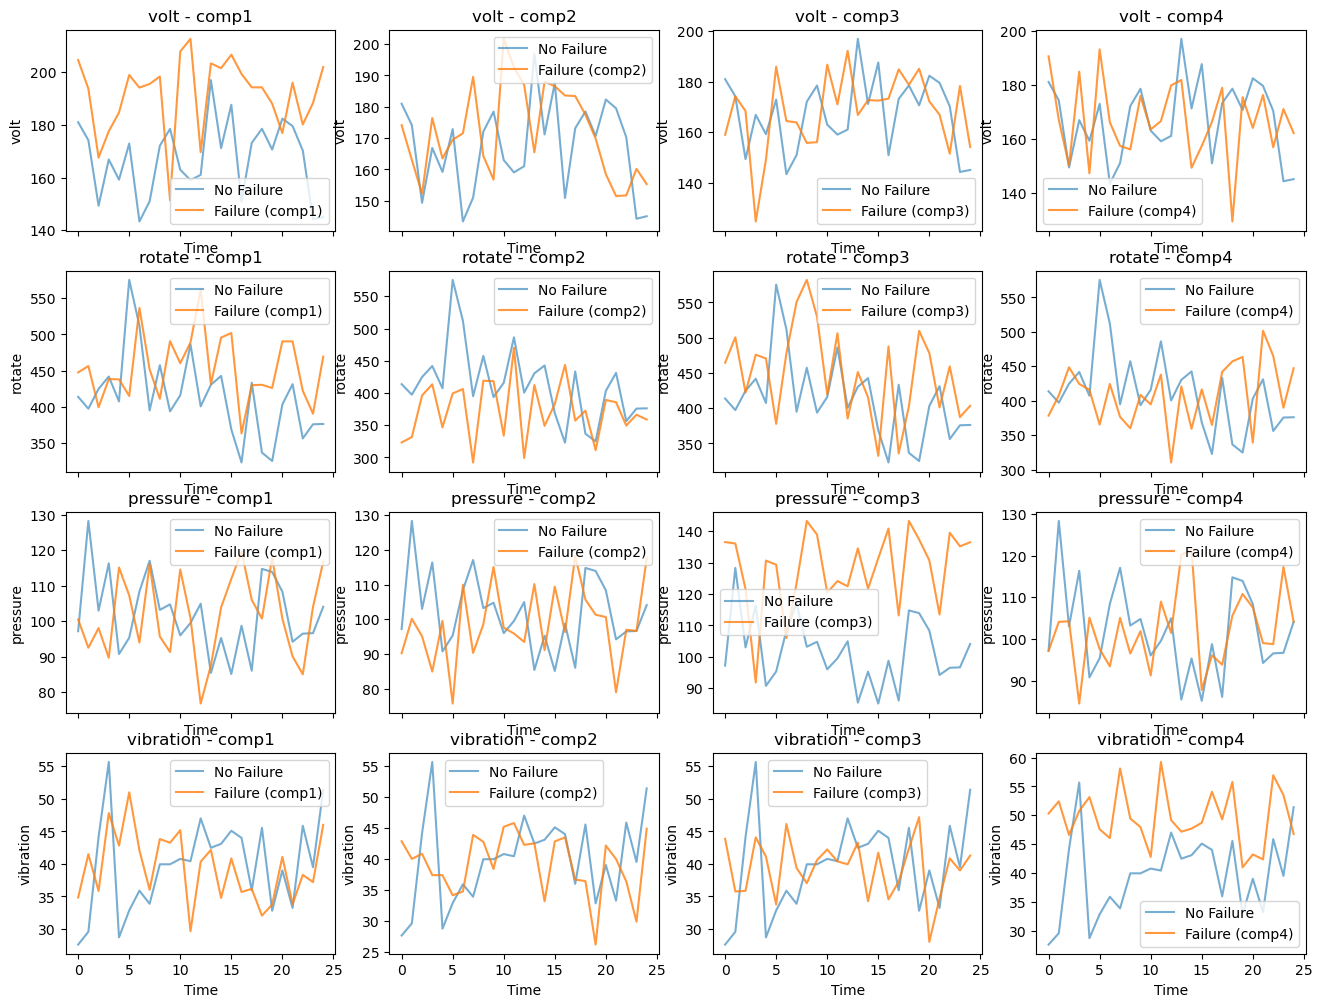

In [83]:
# Define telemetry variables and component labels
machine_id = 37
telemetry_vars = ["volt", "rotate", "pressure", "vibration"]
components = ["comp1", "comp2", "comp3", "comp4"]

# Create subplots for each telemetry variable
fig, axes = plt.subplots(len(telemetry_vars), len(components), figsize=(16, 12), sharex=True, sharey=False)

# Plot for each telemetry variable and component failure type
for i, telemetry in enumerate(telemetry_vars):
    for j, comp in enumerate(components):
        ax = axes[i, j]

        # Filter data
        final_features_no_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"].isna())][:25].reset_index()
        final_features_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"] == comp)][:25].reset_index()

        # Plot telemetry trends
        ax.plot(final_features_no_failure.index, final_features_no_failure[telemetry], label="No Failure", alpha=0.6)
        ax.plot(final_features_failure.index, final_features_failure[telemetry], label=f"Failure ({comp})", alpha=0.8)

        # Formatting
        # plt.title(f"For Machine {machine_id}")
        ax.set_title(f"{telemetry} - {comp}")
        ax.set_xlabel("Time")
        ax.set_ylabel(telemetry)
        ax.legend()

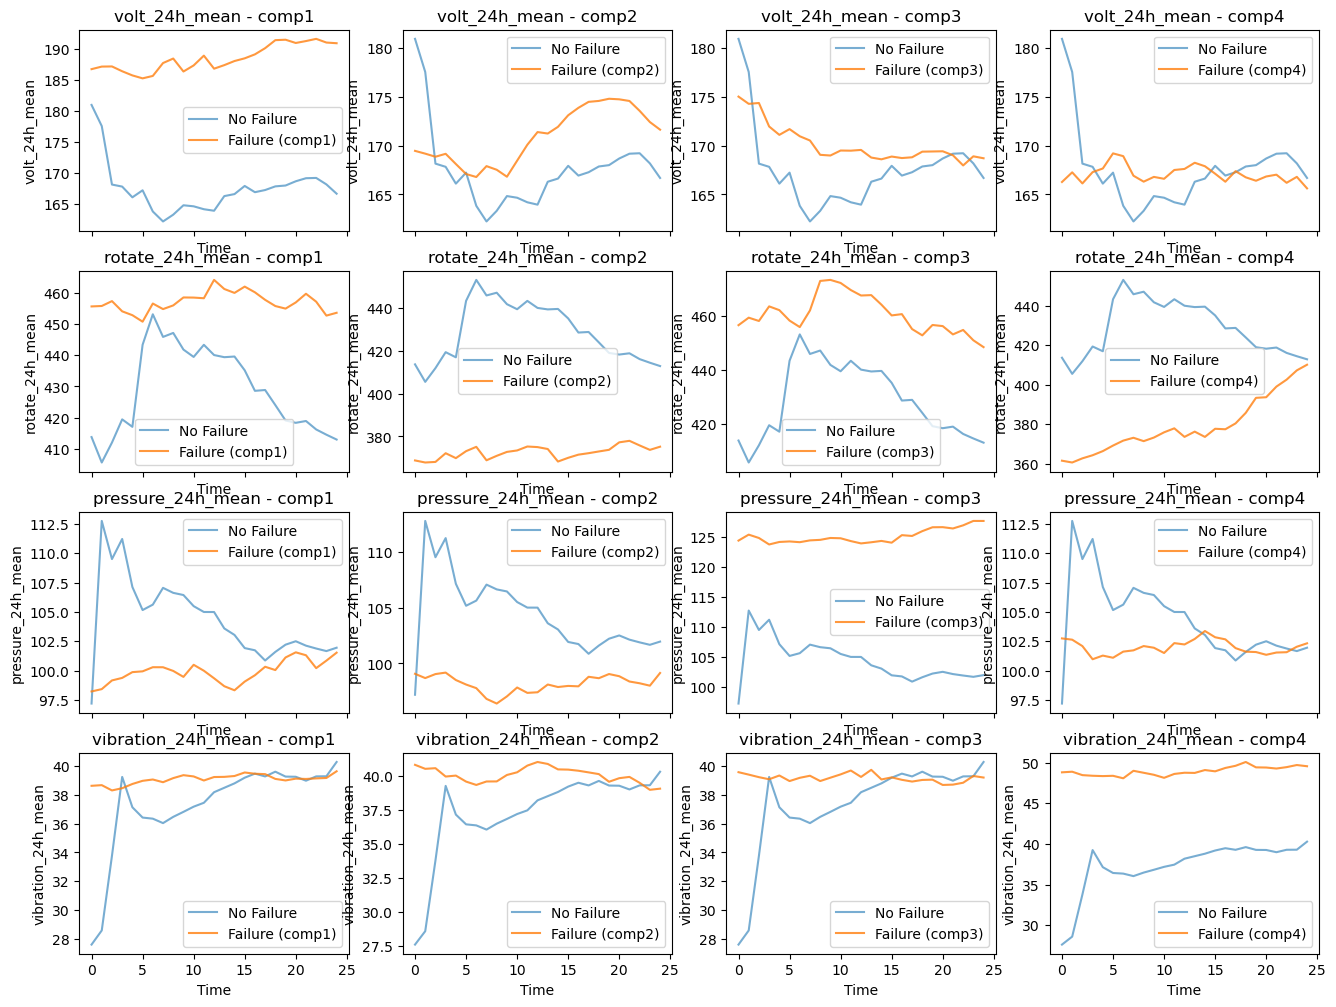

In [89]:
# Define telemetry variables and component labels
machine_id = 37
telemetry_vars = ["volt_24h_mean", "rotate_24h_mean", "pressure_24h_mean", "vibration_24h_mean"]
components = ["comp1", "comp2", "comp3", "comp4"]

# Create subplots for each telemetry variable
fig, axes = plt.subplots(len(telemetry_vars), len(components), figsize=(16, 12), sharex=True, sharey=False)

# Plot for each telemetry variable and component failure type
for i, telemetry in enumerate(telemetry_vars):
    for j, comp in enumerate(components):
        ax = axes[i, j]

        # Filter data
        final_features_no_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"].isna())][:25].reset_index()
        final_features_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"] == comp)][:25].reset_index()

        # Plot telemetry trends
        ax.plot(final_features_no_failure.index, final_features_no_failure[telemetry], label="No Failure", alpha=0.6)
        ax.plot(final_features_failure.index, final_features_failure[telemetry], label=f"Failure ({comp})", alpha=0.8)

        # Formatting
        # plt.title(f"For Machine {machine_id}")
        ax.set_title(f"{telemetry} - {comp}")
        ax.set_xlabel("Time")
        ax.set_ylabel(telemetry)
        ax.legend()

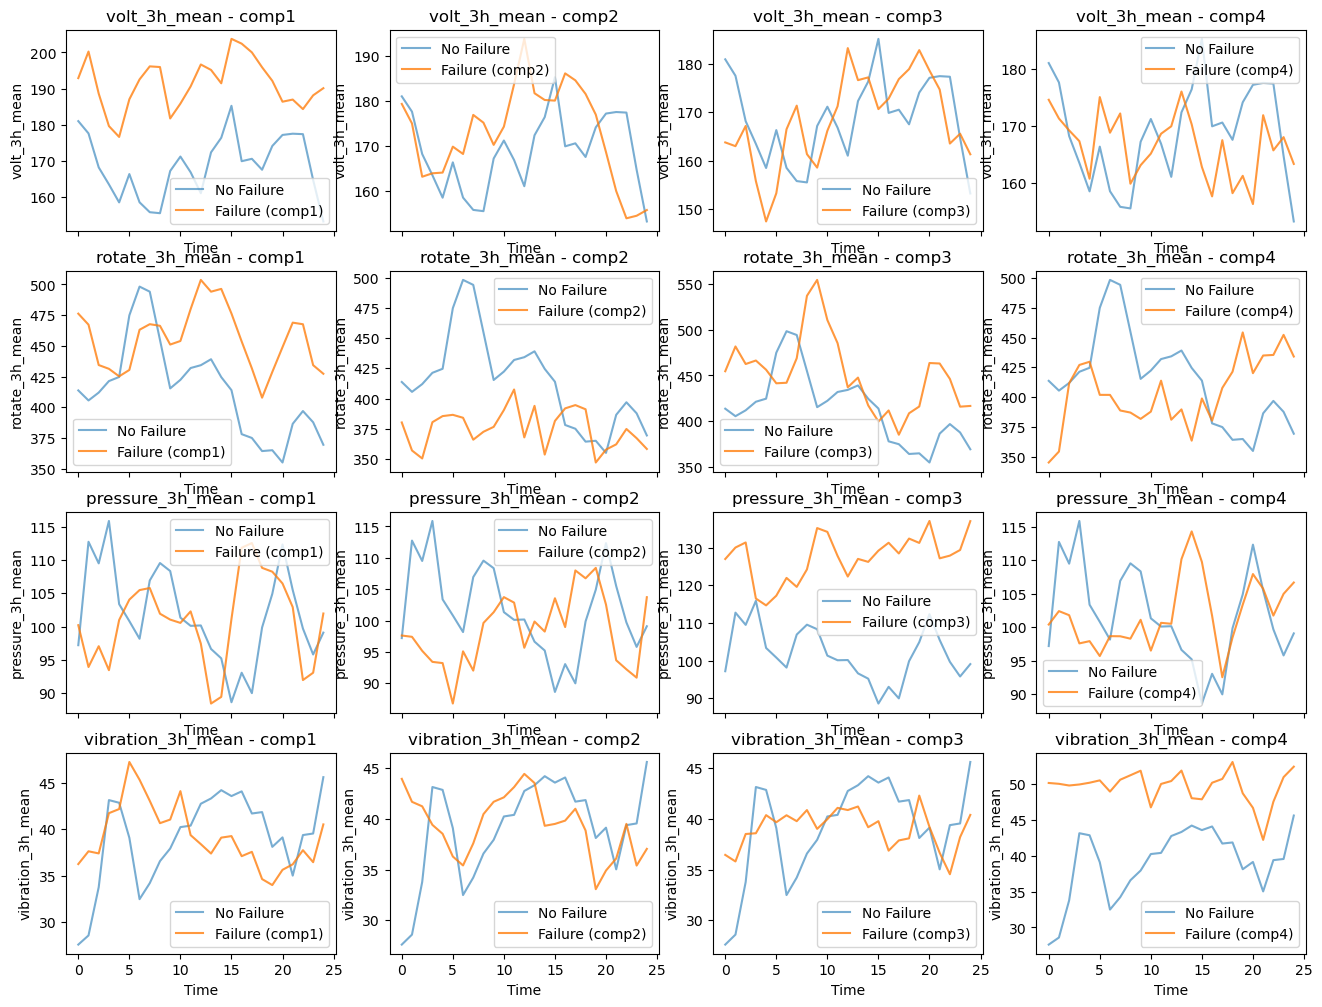

In [90]:
# Define telemetry variables and component labels
machine_id = 37
telemetry_vars = ["volt_3h_mean", "rotate_3h_mean", "pressure_3h_mean", "vibration_3h_mean"]
components = ["comp1", "comp2", "comp3", "comp4"]

# Create subplots for each telemetry variable
fig, axes = plt.subplots(len(telemetry_vars), len(components), figsize=(16, 12), sharex=True, sharey=False)

# Plot for each telemetry variable and component failure type
for i, telemetry in enumerate(telemetry_vars):
    for j, comp in enumerate(components):
        ax = axes[i, j]

        # Filter data
        final_features_no_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"].isna())][:25].reset_index()
        final_features_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"] == comp)][:25].reset_index()

        # Plot telemetry trends
        ax.plot(final_features_no_failure.index, final_features_no_failure[telemetry], label="No Failure", alpha=0.6)
        ax.plot(final_features_failure.index, final_features_failure[telemetry], label=f"Failure ({comp})", alpha=0.8)

        # Formatting
        # plt.title(f"For Machine {machine_id}")
        ax.set_title(f"{telemetry} - {comp}")
        ax.set_xlabel("Time")
        ax.set_ylabel(telemetry)
        ax.legend()

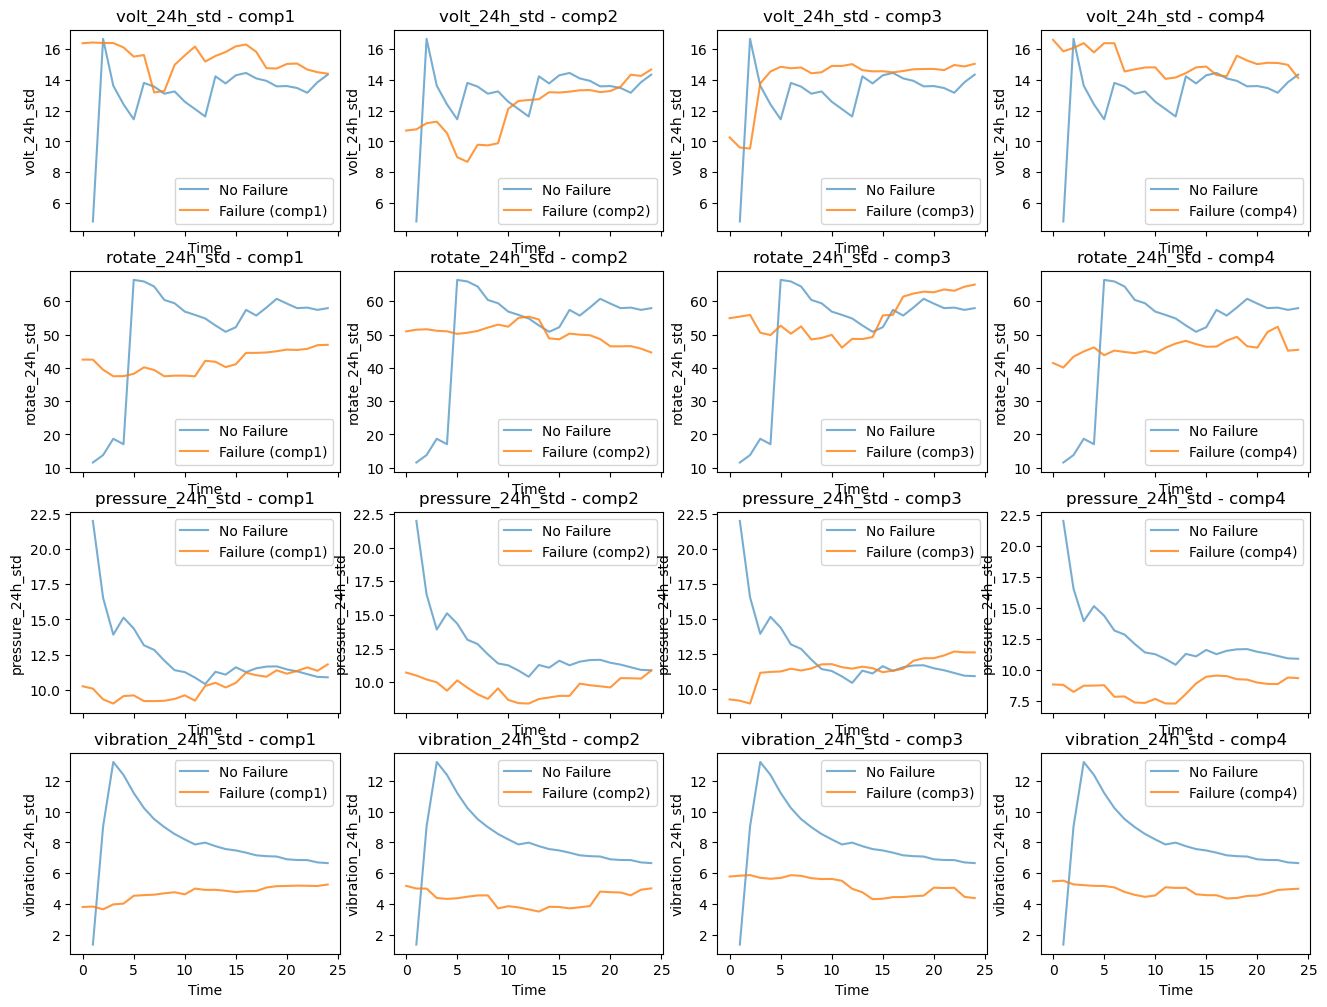

In [91]:
# Define telemetry variables and component labels
machine_id = 37
telemetry_vars = ["volt_24h_std", "rotate_24h_std", "pressure_24h_std", "vibration_24h_std"]
components = ["comp1", "comp2", "comp3", "comp4"]

# Create subplots for each telemetry variable
fig, axes = plt.subplots(len(telemetry_vars), len(components), figsize=(16, 12), sharex=True, sharey=False)

# Plot for each telemetry variable and component failure type
for i, telemetry in enumerate(telemetry_vars):
    for j, comp in enumerate(components):
        ax = axes[i, j]

        # Filter data
        final_features_no_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"].isna())][:25].reset_index()
        final_features_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"] == comp)][:25].reset_index()

        # Plot telemetry trends
        ax.plot(final_features_no_failure.index, final_features_no_failure[telemetry], label="No Failure", alpha=0.6)
        ax.plot(final_features_failure.index, final_features_failure[telemetry], label=f"Failure ({comp})", alpha=0.8)

        # Formatting
        # plt.title(f"For Machine {machine_id}")
        ax.set_title(f"{telemetry} - {comp}")
        ax.set_xlabel("Time")
        ax.set_ylabel(telemetry)
        ax.legend()

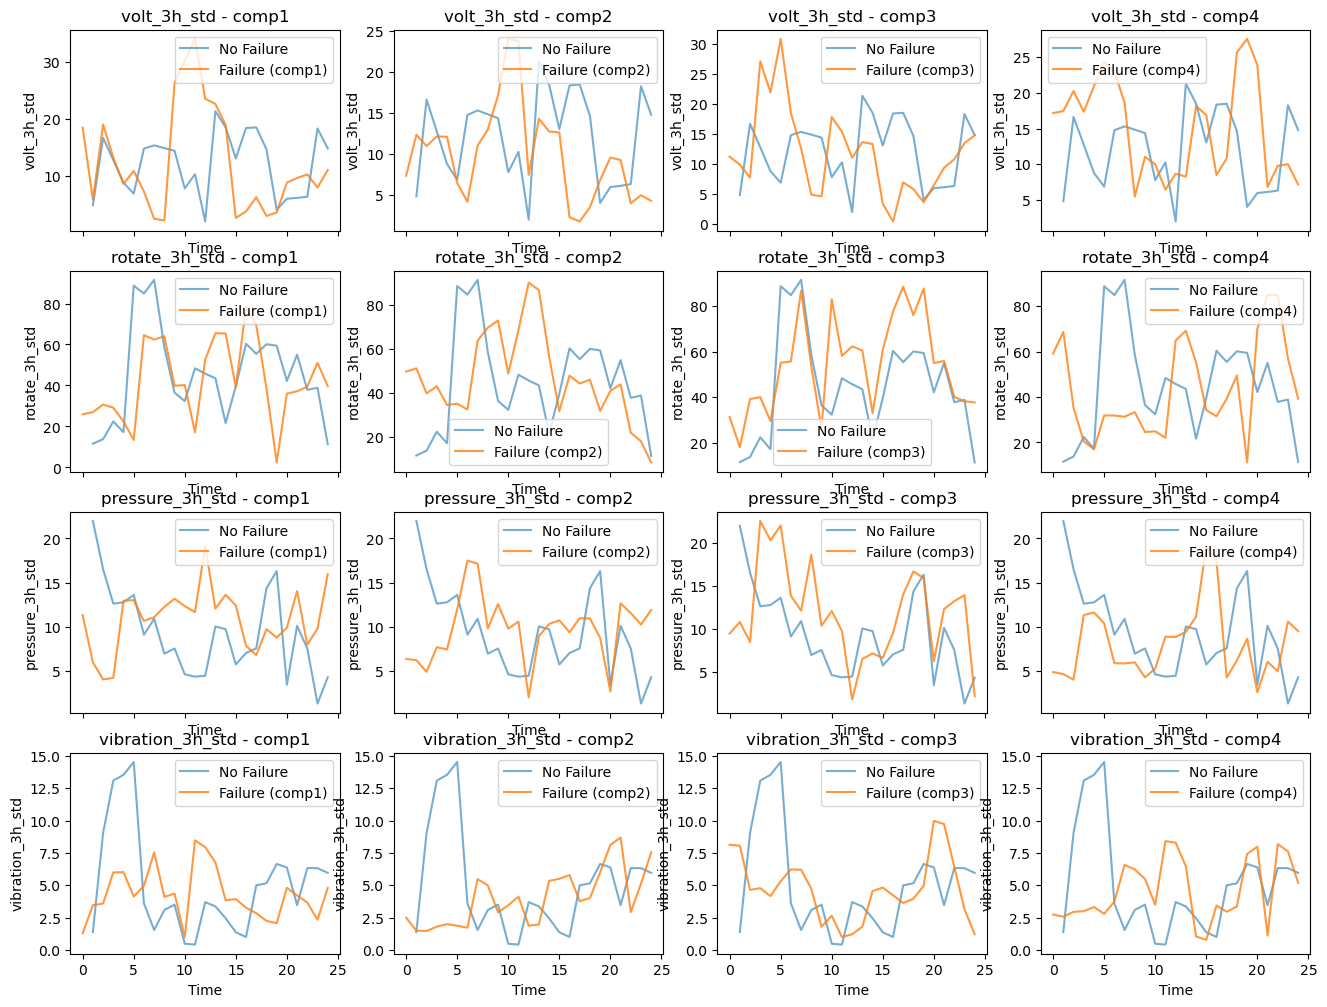

In [92]:
# Define telemetry variables and component labels
machine_id = 37
telemetry_vars = ["volt_3h_std", "rotate_3h_std", "pressure_3h_std", "vibration_3h_std"]
components = ["comp1", "comp2", "comp3", "comp4"]

# Create subplots for each telemetry variable
fig, axes = plt.subplots(len(telemetry_vars), len(components), figsize=(16, 12), sharex=True, sharey=False)

# Plot for each telemetry variable and component failure type
for i, telemetry in enumerate(telemetry_vars):
    for j, comp in enumerate(components):
        ax = axes[i, j]

        # Filter data
        final_features_no_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"].isna())][:25].reset_index()
        final_features_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"] == comp)][:25].reset_index()

        # Plot telemetry trends
        ax.plot(final_features_no_failure.index, final_features_no_failure[telemetry], label="No Failure", alpha=0.6)
        ax.plot(final_features_failure.index, final_features_failure[telemetry], label=f"Failure ({comp})", alpha=0.8)

        # Formatting
        # plt.title(f"For Machine {machine_id}")
        ax.set_title(f"{telemetry} - {comp}")
        ax.set_xlabel("Time")
        ax.set_ylabel(telemetry)
        ax.legend()

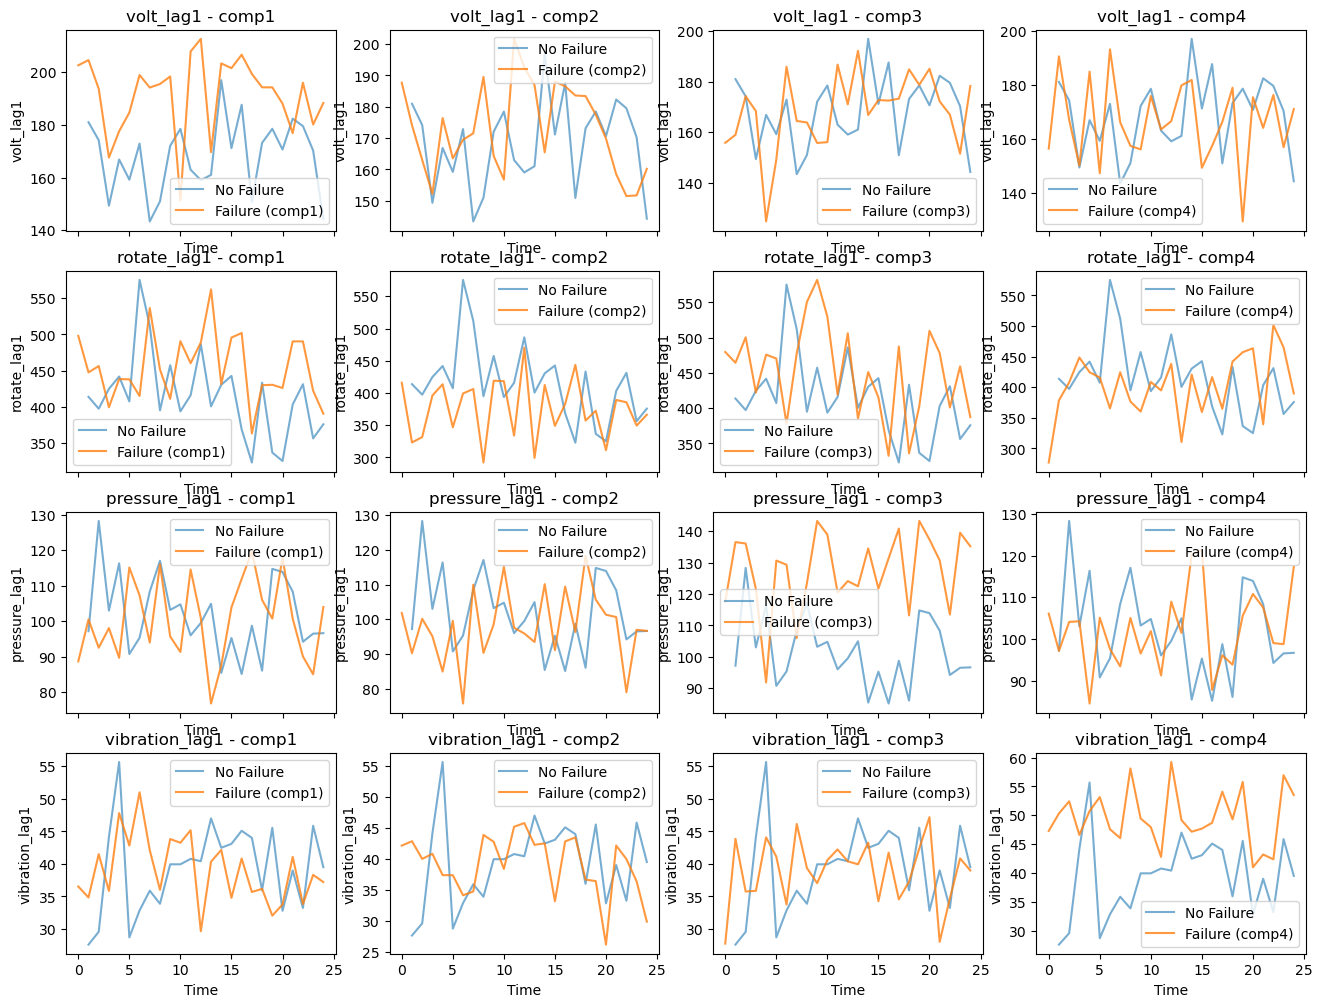

In [93]:
# Define telemetry variables and component labels
machine_id = 37
telemetry_vars = ["volt_lag1", "rotate_lag1", "pressure_lag1", "vibration_lag1"]
components = ["comp1", "comp2", "comp3", "comp4"]

# Create subplots for each telemetry variable
fig, axes = plt.subplots(len(telemetry_vars), len(components), figsize=(16, 12), sharex=True, sharey=False)

# Plot for each telemetry variable and component failure type
for i, telemetry in enumerate(telemetry_vars):
    for j, comp in enumerate(components):
        ax = axes[i, j]

        # Filter data
        final_features_no_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"].isna())][:25].reset_index()
        final_features_failure = final_features[(final_features["machineID"] == machine_id) & (final_features["label"] == comp)][:25].reset_index()

        # Plot telemetry trends
        ax.plot(final_features_no_failure.index, final_features_no_failure[telemetry], label="No Failure", alpha=0.6)
        ax.plot(final_features_failure.index, final_features_failure[telemetry], label=f"Failure ({comp})", alpha=0.8)

        # Formatting
        # plt.title(f"For Machine {machine_id}")
        ax.set_title(f"{telemetry} - {comp}")
        ax.set_xlabel("Time")
        ax.set_ylabel(telemetry)
        ax.legend()

In [42]:
feature_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18


### Task 1: Forecasting Sensor Values (24 hour forecast)

06:26:53 - cmdstanpy - INFO - Chain [1] start processing
06:26:55 - cmdstanpy - INFO - Chain [1] done processing


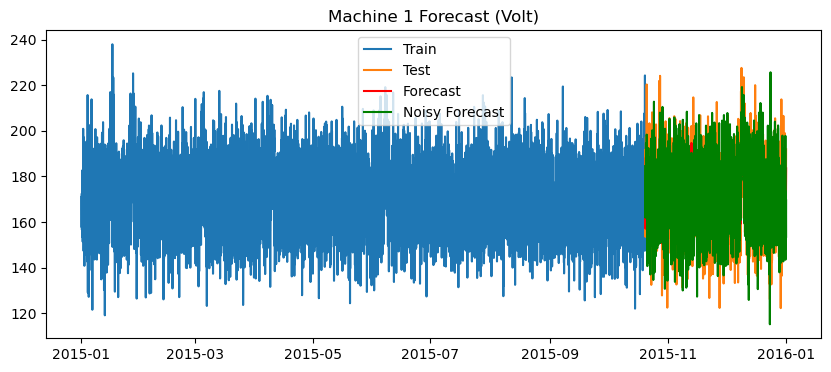

06:26:58 - cmdstanpy - INFO - Chain [1] start processing
06:26:58 - cmdstanpy - INFO - Chain [1] done processing
06:27:00 - cmdstanpy - INFO - Chain [1] start processing
06:27:01 - cmdstanpy - INFO - Chain [1] done processing
06:27:02 - cmdstanpy - INFO - Chain [1] start processing
06:27:03 - cmdstanpy - INFO - Chain [1] done processing
06:27:04 - cmdstanpy - INFO - Chain [1] start processing
06:27:04 - cmdstanpy - INFO - Chain [1] done processing
06:27:06 - cmdstanpy - INFO - Chain [1] start processing
06:27:06 - cmdstanpy - INFO - Chain [1] done processing
06:27:08 - cmdstanpy - INFO - Chain [1] start processing
06:27:08 - cmdstanpy - INFO - Chain [1] done processing
06:27:10 - cmdstanpy - INFO - Chain [1] start processing
06:27:10 - cmdstanpy - INFO - Chain [1] done processing
06:27:12 - cmdstanpy - INFO - Chain [1] start processing
06:27:12 - cmdstanpy - INFO - Chain [1] done processing
06:27:14 - cmdstanpy - INFO - Chain [1] start processing
06:27:14 - cmdstanpy - INFO - Chain [1]

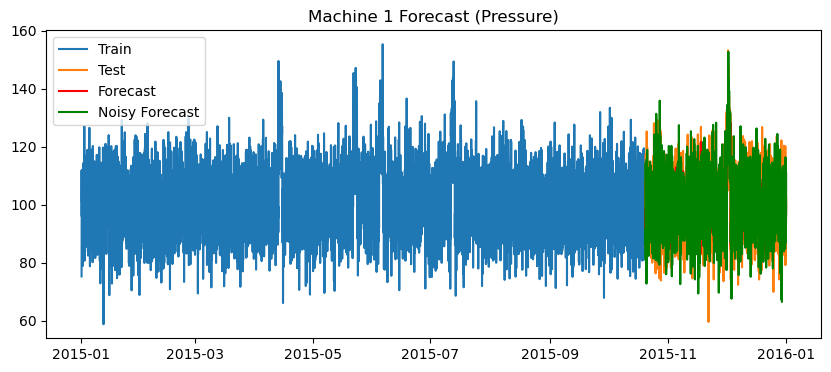

06:30:12 - cmdstanpy - INFO - Chain [1] start processing
06:30:13 - cmdstanpy - INFO - Chain [1] done processing
06:30:14 - cmdstanpy - INFO - Chain [1] start processing
06:30:15 - cmdstanpy - INFO - Chain [1] done processing
06:30:16 - cmdstanpy - INFO - Chain [1] start processing
06:30:17 - cmdstanpy - INFO - Chain [1] done processing
06:30:18 - cmdstanpy - INFO - Chain [1] start processing
06:30:18 - cmdstanpy - INFO - Chain [1] done processing
06:30:20 - cmdstanpy - INFO - Chain [1] start processing
06:30:21 - cmdstanpy - INFO - Chain [1] done processing
06:30:22 - cmdstanpy - INFO - Chain [1] start processing
06:30:23 - cmdstanpy - INFO - Chain [1] done processing
06:30:24 - cmdstanpy - INFO - Chain [1] start processing
06:30:24 - cmdstanpy - INFO - Chain [1] done processing
06:30:26 - cmdstanpy - INFO - Chain [1] start processing
06:30:26 - cmdstanpy - INFO - Chain [1] done processing
06:30:28 - cmdstanpy - INFO - Chain [1] start processing
06:30:28 - cmdstanpy - INFO - Chain [1]

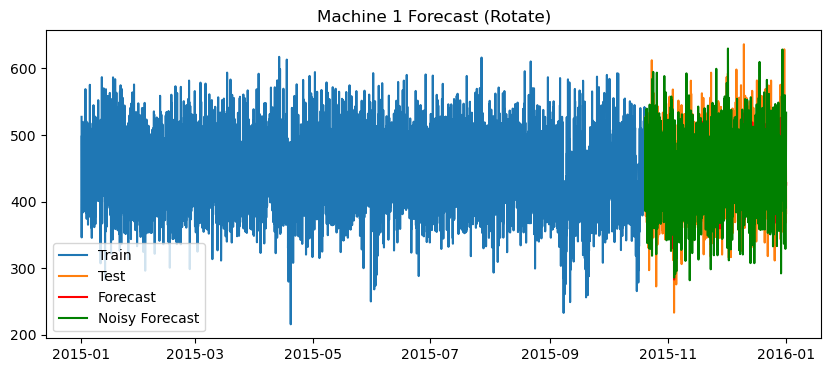

06:33:28 - cmdstanpy - INFO - Chain [1] start processing
06:33:28 - cmdstanpy - INFO - Chain [1] done processing
06:33:30 - cmdstanpy - INFO - Chain [1] start processing
06:33:30 - cmdstanpy - INFO - Chain [1] done processing
06:33:32 - cmdstanpy - INFO - Chain [1] start processing
06:33:32 - cmdstanpy - INFO - Chain [1] done processing
06:33:34 - cmdstanpy - INFO - Chain [1] start processing
06:33:34 - cmdstanpy - INFO - Chain [1] done processing
06:33:35 - cmdstanpy - INFO - Chain [1] start processing
06:33:36 - cmdstanpy - INFO - Chain [1] done processing
06:33:37 - cmdstanpy - INFO - Chain [1] start processing
06:33:38 - cmdstanpy - INFO - Chain [1] done processing
06:33:40 - cmdstanpy - INFO - Chain [1] start processing
06:33:40 - cmdstanpy - INFO - Chain [1] done processing
06:33:42 - cmdstanpy - INFO - Chain [1] start processing
06:33:42 - cmdstanpy - INFO - Chain [1] done processing
06:33:44 - cmdstanpy - INFO - Chain [1] start processing
06:33:44 - cmdstanpy - INFO - Chain [1]

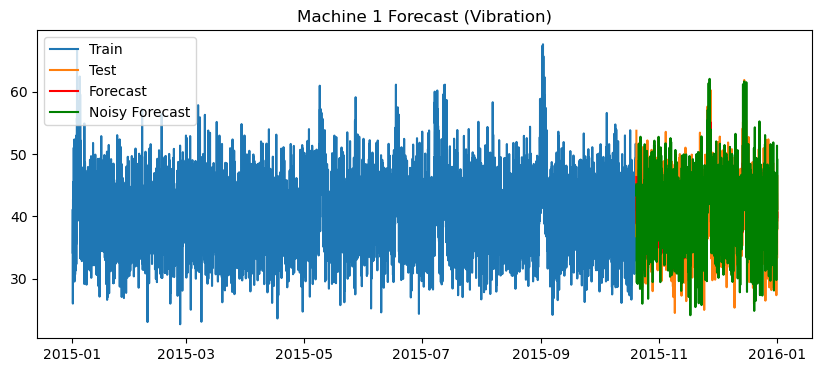

06:36:42 - cmdstanpy - INFO - Chain [1] start processing
06:36:43 - cmdstanpy - INFO - Chain [1] done processing
06:36:44 - cmdstanpy - INFO - Chain [1] start processing
06:36:44 - cmdstanpy - INFO - Chain [1] done processing
06:36:46 - cmdstanpy - INFO - Chain [1] start processing
06:36:46 - cmdstanpy - INFO - Chain [1] done processing
06:36:48 - cmdstanpy - INFO - Chain [1] start processing
06:36:49 - cmdstanpy - INFO - Chain [1] done processing
06:36:50 - cmdstanpy - INFO - Chain [1] start processing
06:36:51 - cmdstanpy - INFO - Chain [1] done processing
06:36:52 - cmdstanpy - INFO - Chain [1] start processing
06:36:52 - cmdstanpy - INFO - Chain [1] done processing
06:36:54 - cmdstanpy - INFO - Chain [1] start processing
06:36:54 - cmdstanpy - INFO - Chain [1] done processing
06:36:56 - cmdstanpy - INFO - Chain [1] start processing
06:36:57 - cmdstanpy - INFO - Chain [1] done processing
06:36:58 - cmdstanpy - INFO - Chain [1] start processing
06:36:58 - cmdstanpy - INFO - Chain [1]

In [95]:
# List of sensors to build models for
sensors = ['volt', 'pressure', 'rotate', 'vibration']

# Make a copy of your data
ts_data = feature_df.copy()

# Create time-based features (they are common for all sensors)
ts_data["hour"] = ts_data["datetime"].dt.hour
ts_data["day_of_week"] = ts_data["datetime"].dt.dayofweek

# For each sensor, compute rolling statistics by machine
for sensor in sensors:
    roll_mean_name = f"{sensor}_rolling_mean"
    roll_std_name = f"{sensor}_rolling_std"
    
    ts_data[roll_mean_name] = (
        ts_data.groupby('machineID')[sensor]
          .rolling(window=3)
          .mean()
          .reset_index(level=0, drop=True)
    )

    ts_data[roll_std_name] = (
        ts_data.groupby('machineID')[sensor]
          .rolling(window=3)
          .std()
          .reset_index(level=0, drop=True)
    )

# Create dictionaries to hold evaluation metrics and fitted models
results_prophet = {}
fitted_models = {}  # key: (machineID, sensor), value: Prophet model

# Create a folder to store saved models (if it doesn't exist)
model_save_dir = 'saved_prophet_models'
os.makedirs(model_save_dir, exist_ok=True)

# Loop over each sensor
for sensor in sensors:
    # Set names for rolling stats
    roll_mean_name = f"{sensor}_rolling_mean"
    roll_std_name = f"{sensor}_rolling_std"
    
    # Loop over each machine
    for machine in ts_data['machineID'].unique():
        # Subset data for the machine and sort by datetime
        machine_data = ts_data[ts_data['machineID'] == machine].sort_values('datetime')
        
        # For Prophet, we need a DataFrame with columns 'ds' and 'y'
        # plus the extra regressors
        df_prophet = machine_data.drop(['model','age'], axis=1).rename(columns={
            'datetime': 'ds',
            sensor: 'y'
        })
        
        # (Optional) Drop rows with missing y or regressors
        df_prophet = df_prophet.dropna(subset=['y', 'hour', 'day_of_week', roll_mean_name, roll_std_name])
        
        # Train-Test Split (80/20 split)
        split_index = int(len(df_prophet) * 0.8)
        train_df = df_prophet.iloc[:split_index].copy()
        test_df = df_prophet.iloc[split_index:].copy()
        
        try:
            # Initialize Prophet with desired seasonality settings
            model = Prophet(daily_seasonality=True)
            # Add extra regressors specific to the sensor model
            model.add_regressor('hour')
            model.add_regressor('day_of_week')
            model.add_regressor(roll_mean_name)
            model.add_regressor(roll_std_name)
            
            # Fit the model on the training data
            model.fit(train_df)
            
            # Create future dataframe for the test period (using hourly frequency)
            future = model.make_future_dataframe(periods=len(test_df), freq='h')
            
            # Merge in the extra regressors by matching on 'ds'
            regressor_cols = ['ds', 'hour', 'day_of_week', roll_mean_name, roll_std_name]
            future = future.merge(df_prophet[regressor_cols], on='ds', how='left')
            
            # Generate forecast
            forecast_df = model.predict(future)
            
            # Compare only the forecast corresponding to the test period
            pred_df = forecast_df[['ds', 'yhat']].iloc[-len(test_df):].copy()
            test_df.set_index('ds', inplace=True)
            pred_df.set_index('ds', inplace=True)
            
            # Compute error metrics
            mae = mean_absolute_error(test_df['y'], pred_df['yhat'])
            rmse = np.sqrt(mean_squared_error(test_df['y'], pred_df['yhat']))
            mape = np.mean(np.abs((test_df['y'] - pred_df['yhat']) / test_df['y'])) * 100
            
            # Store metrics in results with key (machine, sensor)
            results_prophet[(machine, sensor)] = {
                'mae': mae,
                'rmse': rmse,
                'mape': mape
            }
            
            # Save the fitted model in our dictionary for later inference
            fitted_models[(machine, sensor)] = model
            
            # Save the model to disk for efficient future inference
            model_filename = os.path.join(model_save_dir, f"prophet_model_machine{machine}_{sensor}.pkl")
            joblib.dump(model, model_filename)
            
            # Optionally, plot forecasts for the first machine of each sensor
            if machine == ts_data['machineID'].unique()[0]:
                resid_std = np.std(train_df['y'] - model.predict(train_df)['yhat'])
                noisy_forecast = pred_df['yhat'] + np.random.normal(loc=0, scale=resid_std, size=len(pred_df))
                
                plt.figure(figsize=(10, 4))
                plt.plot(train_df['ds'], train_df['y'], label='Train')
                plt.plot(test_df.index, test_df['y'], label='Test')
                plt.plot(pred_df.index, pred_df['yhat'], label='Forecast', color='red')
                plt.plot(pred_df.index, noisy_forecast, label='Noisy Forecast', color='green')
                plt.title(f'Machine {machine} Forecast ({sensor.capitalize()})')
                plt.legend()
                plt.show()
                
        except Exception as e:
            print(f"Prophet modeling failed for Machine {machine}, Sensor {sensor}: {e}")
            continue

# Create a DataFrame summarizing evaluation metrics for all models
results_prophet_df = pd.DataFrame.from_dict(results_prophet, orient='index')
results_prophet_df.index = pd.MultiIndex.from_tuples(results_prophet_df.index, names=['machineID', 'sensor'])
# print(results_prophet_df)
# print(results_prophet_df.describe())

# Optionally, save the evaluation metrics to disk
results_prophet_df.to_csv('prophet_model_evaluation_metrics.csv', index=True)


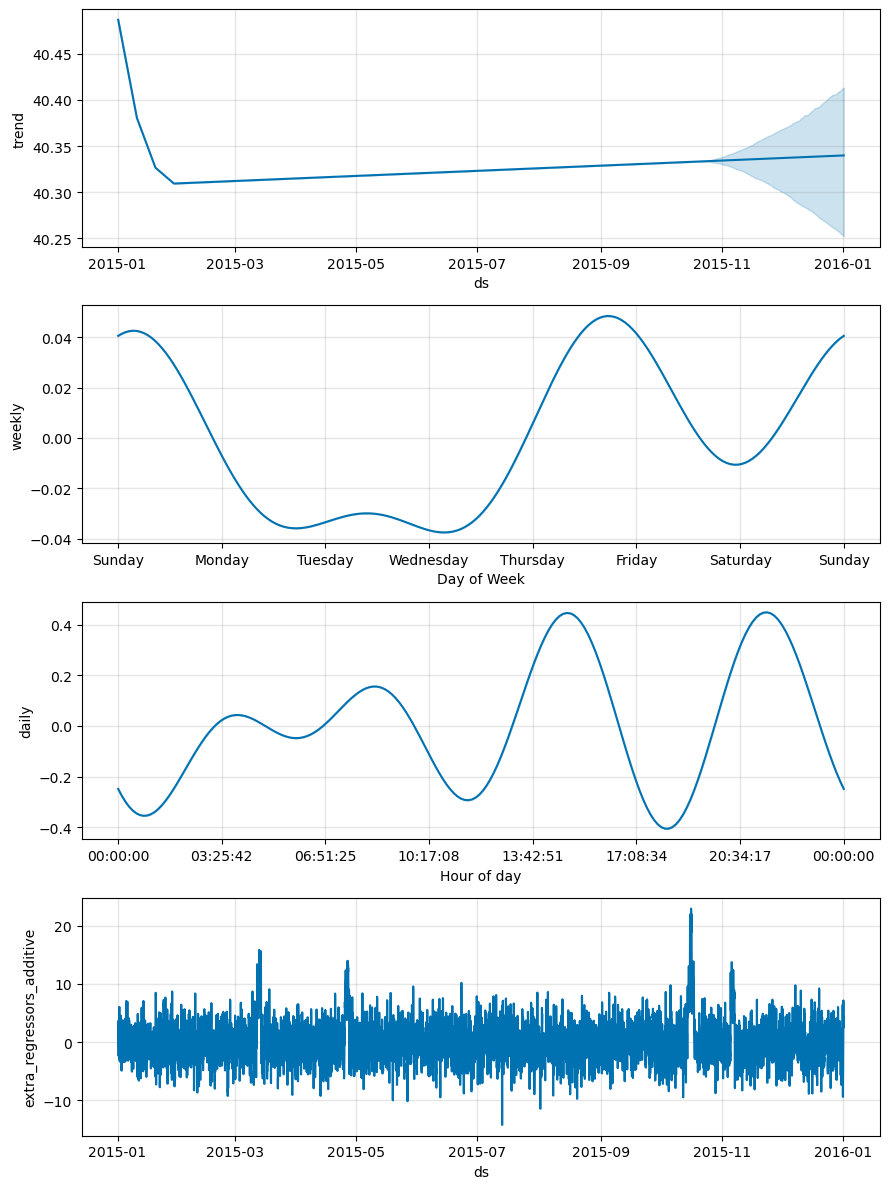

In [96]:
fig = model.plot_components(forecast_df)
plt.show()

In [97]:
print(model.params)

OrderedDict([('lp__', array([[16117.6]])), ('k', array([[-0.0487392]])), ('m', array([[0.595222]])), ('delta', array([[ 2.37906e-02,  1.69792e-02,  8.35807e-03,  1.59952e-07,
         1.29218e-08,  9.81499e-08, -9.22880e-08,  2.19492e-07,
        -3.34135e-08, -2.58380e-07, -2.07762e-08, -2.56095e-07,
        -1.20312e-07, -6.95121e-08,  2.30800e-08, -1.30885e-07,
        -1.09411e-07,  9.05848e-08,  2.54354e-08, -1.86427e-07,
        -1.47683e-07,  7.10213e-08,  1.40281e-08, -2.48129e-07,
        -6.74647e-08]])), ('sigma_obs', array([[0.0607929]])), ('beta', array([[ 4.37405e-04, -4.85646e-05,  1.21452e-04,  2.73636e-04,
         2.61945e-04, -1.39909e-04, -6.50896e-04, -4.23328e-04,
        -4.68710e-04, -2.35397e-04, -3.25575e-03,  5.39210e-04,
        -5.45989e-04, -3.53318e-03, -7.64859e-04, -4.34767e-04,
         4.93740e-02,  3.95279e-04]])), ('trend', array([[0.595222, 0.595215, 0.595208, ..., 0.592962, 0.592962, 0.592962]]))])


In [109]:
results_prophet_df 

# Observe highest error for rotate (range is 400ish) 

,,mae,rmse,mape
machineID,sensor,,,
1,volt,9.846668,12.295428,5.822277
2,volt,9.559634,12.075444,5.669829
3,volt,9.977607,12.523685,5.928489
4,volt,9.707266,12.321011,5.764559
5,volt,9.841783,12.390585,5.846333
...,...,...,...,...
96,vibration,3.247184,4.058951,8.277964
97,vibration,3.336898,4.190888,8.475279
98,vibration,3.264618,4.112304,8.318807


### Task 2: Predict Failure in next 24 hours

In [34]:
predict_df = final_features.copy()
predict_df = pd.get_dummies(predict_df, columns=['model'], drop_first=True)

In [35]:
predict_df.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'age', 'failure', 'errorID_error1', 'errorID_error2', 'errorID_error3',
       'errorID_error4', 'errorID_error5', 'label', 'days_since_comp1',
       'days_since_comp2', 'days_since_comp3', 'days_since_comp4',
       'volt_24h_mean', 'volt_24h_std', 'volt_3h_mean', 'volt_3h_std',
       'volt_lag1', 'rotate_24h_mean', 'rotate_24h_std', 'rotate_3h_mean',
       'rotate_3h_std', 'rotate_lag1', 'pressure_24h_mean', 'pressure_24h_std',
       'pressure_3h_mean', 'pressure_3h_std', 'pressure_lag1',
       'vibration_24h_mean', 'vibration_24h_std', 'vibration_3h_mean',
       'vibration_3h_std', 'vibration_lag1', 'total_errors', 'model_model2',
       'model_model3', 'model_model4'],
      dtype='object')

In [37]:
target = 'label'
# Drop columns that should not be used as features
drop_cols = ['datetime', 'failure', 'label']
features = [col for col in predict_df.columns if col not in drop_cols]

X = predict_df[features]
y = predict_df[target]

X = X.replace({'none':np.nan})
X.dropna(inplace=True)
y = y.loc[X.index]

split_date = predict_df['datetime'].quantile(0.8)
train_mask = predict_df['datetime'] < split_date
test_mask = predict_df['datetime'] >= split_date

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

le = LabelEncoder()
y_train = le.fit_transform(y_train)  # Convert labels to numbers
y_test = le.transform(y_test)

X_train = X_train.astype({col: int for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: int for col in X_test.select_dtypes(include=['bool']).columns})

# Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300} (trained on Colab GPU)

# ---------------------------
# Model Training
# ---------------------------
model = XGBClassifier(tree_method='hist', random_state=42, learning_rate= 0.1, max_depth= 7, n_estimators= 300)
model.fit(X_train, y_train)

# ---------------------------
# Model Evaluation
# ---------------------------
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_1283/2425146571.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[train_mask]
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_1283/2425146571.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X[test_mask]


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       877
           1       0.84      0.90      0.87      1235
           2       0.91      0.94      0.92       557
           3       0.87      0.89      0.88       659
           4       1.00      1.00      1.00    171972

    accuracy                           1.00    175300
   macro avg       0.90      0.92      0.91    175300
weighted avg       1.00      1.00      1.00    175300



In [38]:
le.classes_

array(['comp1', 'comp2', 'comp3', 'comp4', None], dtype=object)

Text(0.5, 0, 'Features')

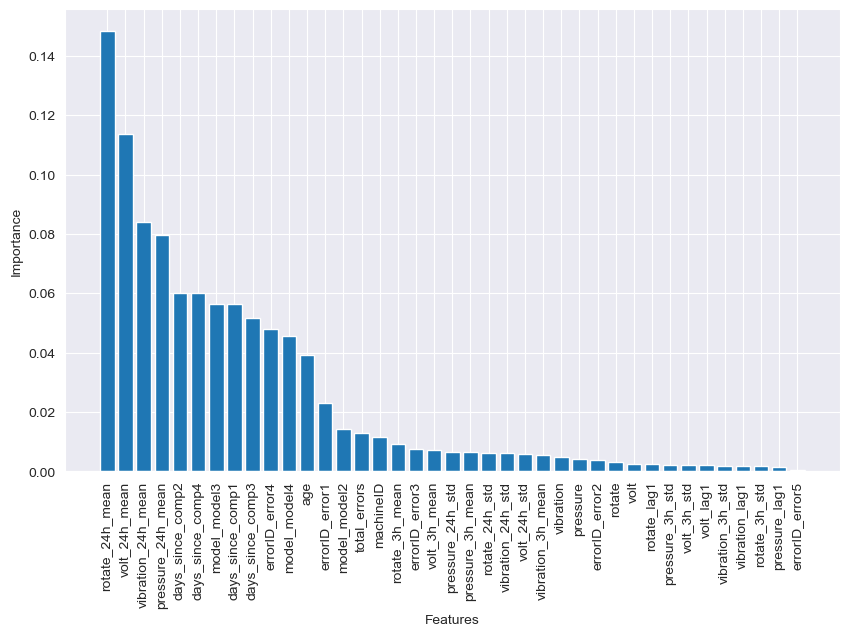

In [39]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
importances = pd.DataFrame({"columns":X_test.columns, "importance":model.feature_importances_}).sort_values("importance",ascending=False)
plt.xticks(range(len(importances["columns"])), importances["columns"])
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances["importance"])), importances["importance"])
plt.ylabel('Importance')
plt.xlabel('Features')